# Experiment of Latent graph signal recovery
by tianpei, Jan 30 2017

##  Network build and Node sample generation

In [1]:
import numpy as np
import scipy as sp
import mpl_toolkits.mplot3d.art3d as art3d
import matplotlib.pyplot as plt
import networkx as nx
from time import strftime, gmtime
#import graph_tool.all as gt
%matplotlib inline  

In [2]:
from latent_signal_network import latent_signal_network as lsn 

'''
def graph_build(size, prob, option):
    
           build graph with two random partition. prob = [p_in, p_out], within-cluster edge prob and 
           between-cluster edge prob. 
           option['seed'] for random seed 
           option['node_dim'] for the dimension of node attributes
    
    [p_in, p_out] = prob
    seed = option['seed']
    node_dim = option['node_dim']
    if option['model'] == 'partition':
        G = nx.random_partition_graph(sizes=size, p_in=p_in, p_out=p_out, seed=seed, directed=False)
        pos = nx.nx_pydot.graphviz_layout(G)
        nx.draw(G, pos=pos, arrows=False, with_labels=True, fontsize= 10, node_color=['r']*size[0]+['b']*size[1], font_color='w')
    elif option['model'] == 'newman':
        G=  nx.newman_watts_strogatz_graph(sum(size), k=4, p=p_out, seed=seed)
        pos = nx.circular_layout(G, dim=2, scale=1.0, center=None)
        nx.draw(G, pos=pos, arrows=False, with_labels=True, fontsize= 10, node_color=['r']*sum(size), font_color='w')
    elif option['model'] == 'power':
        G = nx.powerlaw_cluster_graph(sum(size), m=5, p=p_in, seed=seed)
        pos = nx.nx_pydot.graphviz_layout(G)
        nx.draw(G, pos=pos, arrows=False, with_labels=True, fontsize= 10, node_color=['r']*sum(size), font_color='w')
  
    G_out = nx.Graph()
    G_out.add_nodes_from(G.nodes(), attributes=np.zeros((node_dim,)).T)
    G_out.add_edges_from(G.edges())
    return G_out
'''    

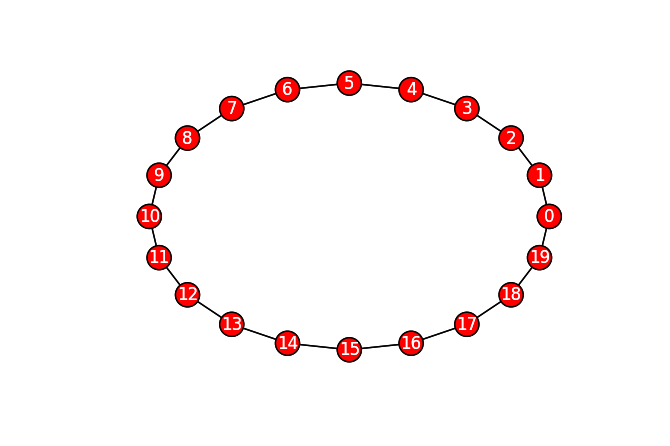

In [3]:
choice = 'newman'

if choice == 'newman':
    size = 20
    prob = 0
    seed = 1000
    d = 10
    option= {'seed': seed, 'node_dim': d, 'model': 'newman'}
    option['k-NN'] = 2
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=True)
elif choice == 'partition':
    size = [10, 10]
    prob = [0.9, 0.1]
    seed = 1000
    d = 10
    option= {'seed': seed, 'node_dim': d, 'model': 'partition'}
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option)
elif choice == 'grid':
    size = [4, 5]
    seed = 1000
    prob = 0.6
    d = 10
    option= {'seed': seed, 'node_dim': d, 'model': 'grid'}
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option)
elif choice == 'binomial':
    size = 20
    prob = 0.18
    seed = 1000
    d = 10
    option= {'seed': seed, 'node_dim': d, 'model': 'binomial'}
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option)

prob = 0.2
G2 = lsn.graph_build(size, prob, option)

prob = 0.6
G6 = lsn.graph_build(size, prob, option)

def node_generate(G, T, sigma, show_plot=False):
    '''
        generate the node attributes in the graph associated with the network topology.
    '''
    
    #initialization
    n = len(G)
    d = len(G.node[0]['attributes'])
    X = np.ndarray((n,d))
    for i, idx in enumerate(G.nodes()):
        d = len(G.node[idx]['attributes'])
        np.random.seed((i*13+7)%100)
        G.node[idx]['attributes'] = sigma*np.random.randn(d)
        X[i,:] = G.node[idx]['attributes']
    
    if show_plot == True:    
        plt.figure(1)
        plt.subplot("511")
        plt.plot(np.arange(X.shape[0]),X[:,0])   
    
    sepT = int(T/5)
    # run a smoothing process on network
    for t in range(T):
        tempG = G.copy()
        for i, idx in enumerate(G.nodes()):
            G.node[idx]['attributes'] = sum([tempG.node[neighbor]['attributes'] for neighbor in tempG[idx]])/len(tempG[idx])
    
        for i, d in G.nodes_iter(data=True):
            X[i,:] = d['attributes']
        
        if t%sepT == 0 and show_plot == True:
            plt.figure(1)
            print("Iteration: " + str(t+1))
            plt.subplot(str(int(T/sepT)+1)+"1"+str(int(t/sepT)+2))
            plt.plot(np.arange(X.shape[0]),X[:,0])
            plt.axis([0, 40, -6, 8])
    
    if show_plot == True:        
        plt.show()        
        
    return [G, X]

In [4]:
G0.node[G0.nodes()[0]]

{'attributes': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

In [11]:
Tmax = 100

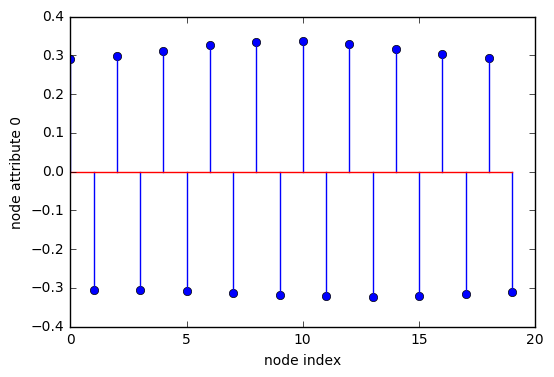

In [12]:
G0_node, X0, hist_tv = LSN.smooth_gsignal_generate(G0, T=Tmax, sigma=5)
plt.figure(1)
plt.stem(np.arange(X0.shape[0]),X0[:,1])
plt.xlabel('node index')
plt.ylabel('node attribute 0')
plt.show()

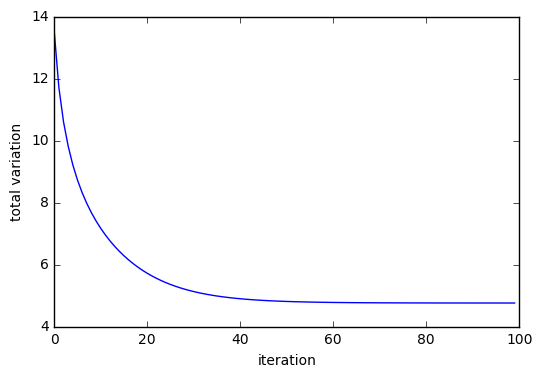

In [13]:
fig2 = plt.figure(2)
plt.plot(np.arange(Tmax), hist_tv, 'b')
plt.xlabel('iteration')
plt.ylabel('total variation')
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_tv.eps"
fig2.savefig(filename)

G6_node, X6 = lsn.smooth_gsignal_generate(G6, T=Tmax, sigma=5)
#plt.figure(3)
#plt.stem(np.arange(X6.shape[0]),X6[:,1])
#plt.show()

In [14]:
if choice != 'newman':
    pos=nx.nx_pydot.graphviz_layout(G0)
elif choice == 'newman':
    pos=nx.circular_layout(G0, dim=2, scale=1.0, center=None)
    
pos_coordinate = np.array([[pos[key][0], pos[key][1]] for key in pos])
X0, nodeIdx = LSN.get_node_attributes(G0)
edge_list = LSN.get_edgelist(G0)

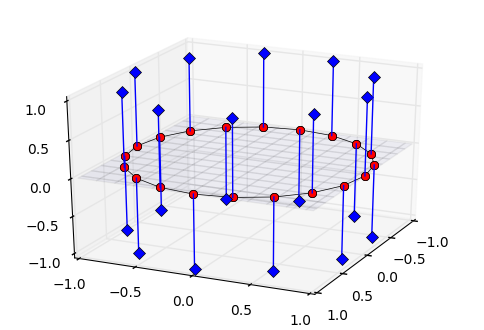

In [15]:
LSN.plot_node_3d(pos_coordinate, edge_list, X0, view_angle=[25,25], nodeIdx=nodeIdx)

In [16]:
tv = LSN.compute_total_variation(G0)
tv

4.7574800016562984